# CONTROL DESIGN

This notebook illustrates the structure of your final project.

In [1]:
if True:
    !pip -q install controlSBML
    !pip -q install tellurium
    !pip -q install control

In [2]:
import numpy as np
from controlSBML import ControlSBML, constants
from controlSBML.grid import Grid

import control
import matplotlib.pyplot as plt
import pandas as pd
import tellurium as te
from typing import List, Optional

# Helpers

In [3]:
s = control.TransferFunction.s
TIMES = np.linspace(0, 5, 500)
WOLF_URL = constants.WOLF_URL

## plotStep

In [4]:
def plotStep(tf, title:str="", times=TIMES, xlim:Optional[list]=None, figsize=[5,5],
      is_plot=True):
    """
    Plots the step response of the transfer function.

    Args:
        tf - transfer function
    """
    _, ax = plt.subplots(1, 1, figsize=figsize)
    _, yv = control.step_response(tf, T=times)
    _ = ax.plot(times, yv)
    if xlim is not None:
        ax.set_xlim(xlim)
    _ = ax.set_title(title)
    if not is_plot:
        plt.close()

# TESTS
tf = control.TransferFunction([5], [1, 5])
plotStep(tf, is_plot=False, xlim=[0, 3])
print("OK!")

OK!


## complex_magnitude

In [5]:
def complex_magnitude(z):
    return (z.real**2 + z.imag**2)**0.5

## ppComplex

In [6]:
def ppComplex(complexes:np.ndarray, round_digits=3)->str:
    """
    Constructs a pretty print representation of a complex number.
    """
    complexes = np.array(complexes)
    complexes = complexes.flatten()
    if not isinstance(complexes, list):
        complexes = [complexes]
    results = []
    if isinstance(complexes[0], np.ndarray):
        complexes = complexes[0]
    for cmpx in complexes:
        try:
            if np.imag(cmpx) == 0:
                results.append(str(round(np.real(cmpx), round_digits)))
            else:
                 results.append(str(round(np.real(cmpx), round_digits)) + "+" + str(round(np.imag(cmpx), round_digits)) + "j")
        except:
            import pdb; pdb.set_trace()
    return ", ".join(results)

# Tests
result = ppComplex((-1.9999999999999998+0j))
result = ppComplex([3+2j, 4])
assert("j" in result)
print("OK!")

OK!


## plotRootLocusWithGains

In [7]:
def plotRootLocusWithGains(open_loop_transfer_function:control.TransferFunction,
      gains:List[float],
      xlim:Optional[np.ndarray]=None,
      title:Optional[str]=None,
      ylim:Optional[np.ndarray]=None,
      is_annotate:bool=True,
      markersize_multiplier:float=100,
      figsize=(5, 5),
      ax=None,
      is_plot:bool=True)->plt.axes:
    """
    Constructs a root locus plot with red hexagons for closed loop poles at different gains.
    Poles at specific gains are indicated by hexigon markers.

    Args:
        open_loop_transfer_function
        gains
        xlim: limits on the axis
        size_multiplier: multiplies by gain to get size of hexagon that marks the pole
        figsize: width and height of figure
        is_annotate: Annotate gain hexigons with gain values
    """
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=figsize)
    # Plot the root locus
    _ = control.root_locus(open_loop_transfer_function, grid=False, plot=True, xlim=xlim,
          ylim=ylim, ax=ax)
    # Construct the title
    if title is None:
        poles = open_loop_transfer_function.poles()
        zeros = open_loop_transfer_function.zeros()
        title = ""
        if len(poles) > 0:
            title += f"FFL poles: {ppComplex(poles)}  "
        if len(zeros) > 0:
            title += f"FFL zeros: {ppComplex(zeros)}"
    ax.set_title(title)
    # Add points for closed loop poles
    for gain in gains:
        closed_loop_transfer_function = control.feedback(gain*open_loop_transfer_function)
        poles = closed_loop_transfer_function.poles()
        xv = []
        yv = []
        for pole in poles:
            xv.append(pole.real)
            yv.append(pole.imag)
        if is_annotate:
            annotation = str(gain)
        else:
            annotation = ""
        ax.scatter(xv, yv, s=markersize_multiplier*gain, marker="h", color="r")
        [ ax.annotate(annotation, (xv[i], yv[i]), color='blue', rotation=25)
             for i in range(len(poles))]
        arrowprops=dict(facecolor='black', shrink=0.05)
    # Plot at zero
    ax.plot([0, 0], [-10, 10], color="grey", linestyle="--")
    #
    if not is_plot:
        plt.close()
        ax = None
    return ax

# Tests
tf = control.zpk([1], [-1, -2], [1])
plotRootLocusWithGains(tf, [0.2, 0.5], markersize_multiplier=200, ylim=[-3, 3], xlim=[-3.5, 0], is_annotate=True,
      figsize=(2, 2), is_plot=False)
print("OK!")

OK!


/usr/local/lib/python3.11/dist-packages/control/rlocus.py:210: FutureWarning:

root_locus() return value of roots, gains is deprecated; use root_locus_map()

/usr/local/lib/python3.11/dist-packages/control/pzmap.py:372: UserWarning:

axis already exists; grid keyword ignored



# 1. Control objective

The biological problem we address is controlling the concentration of pyruvate, ``s5`` in the Wolf model of glycolytic oscillations.  Our control objectives are:
* Regulate ``pyruvate` to a setpoint
* Fast settling times
* Avoid oscillations

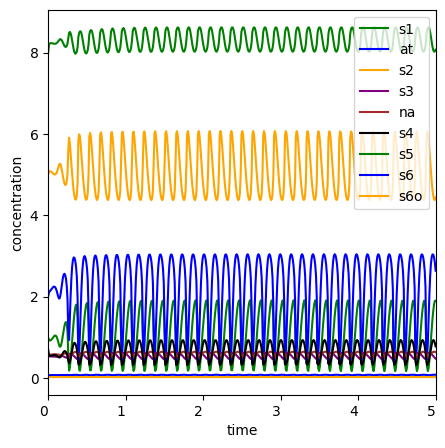

// Created by libAntimony v2.15.0
model *Wolf2000_Glycolytic_Oscillations()

  // Compartments and Species:
  compartment compartment_;
  species s1 in compartment_, at_ in compartment_, s2 in compartment_, s3 in compartment_;
  species na in compartment_, s4 in compartment_, s5 in compartment_, s6 in compartment_;
  species s6o in compartment_;

  // Reactions:
  v1: s1 + 2 at_ -> s2; compartment_*k1*s1*at_/(1 + (at_/ki)^n);
  v2: s2 -> 2 s3; compartment_*k2*s2;
  v3: s3 + na -> s4 + at_; compartment_*((k31*k32*s3*na*(atot - at_) - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
  v4: s4 -> s5 + at_; compartment_*k4*s4*(atot - at_);
  v5: s5 -> s6; compartment_*k5*s5;
  v7: at_ -> ; compartment_*k7*at_;
  v8: s3 -> na; compartment_*k8*s3*(ntot - na);
  v9: s6o -> ; compartment_*k9*s6o;
  v10: s6 -> 0.1 s6o; compartment_*k10*(s6 - s6o);
  v6: s6 -> na; compartment_*k6*s6*(ntot - na);
  v0:  -> s1; compartment_*k0;

  // Species initializations:
  s1 = 1;
  at_ = 2;
 

In [8]:
CTLSB = ControlSBML(WOLF_URL, times=TIMES)
_ = CTLSB.plotModel()
print(CTLSB.getAntimony())

# 2. System definition

The system we analyze has the following characteristics:
1. SBML model: BIOMDELS 206
1. output: na (NADP)
1. input: s5 (pyruvate)
1. directional effect of the input on the output: increasing (See below.)
1. operating region for the input: [0.5, 1] (See below.)
1. range of outputs that can be achieved: [8, 11]  (See below.)

In [9]:
# Global variables
INPUT_NAME = "na"
OUTPUT_NAME = "s5"
CTLSB = ControlSBML(WOLF_URL, input_name=INPUT_NAME, output_name=OUTPUT_NAME, times=TIMES)

The input and output seem to be related within the simulation. We can learn more by controlling the input to see the effect on the output and, from there, determining the operating point and time constants of the system.

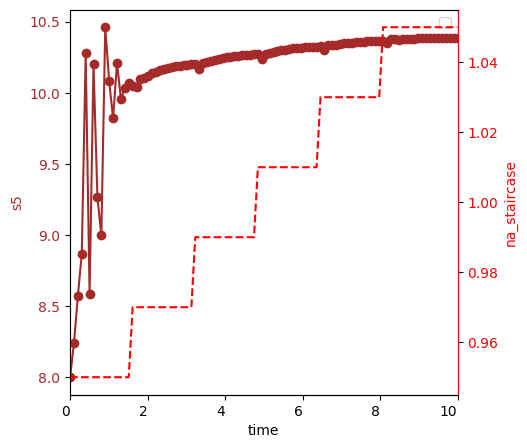

In [10]:
_ = CTLSB.plotStaircaseResponse(initial_value=0.95, final_value=1.05, times=np.linspace(0, 10, 100))

In [11]:
OPERATING_REGION = {'initial_value': 0.95, 'final_value': 1.05, 'times': np.linspace(0,10, 100)}

Clearly, the effect of the input ``na`` causes the output ``s5`` to increase. However, there is an initial transient, sustained oscillations, and a value of ``na`` that is larger than 1.0 has not effect. The output range is [8, 11.5].

The initial transient is likely related to initial conditions set by the model. We can ignore this since they disappear after a few hundred seconds.

# 3. System Identification

System identification describes the system as a transfer function for the operating point specified in system definition. In our system, the input is ``na`` and the output is ``s5``. The input is varied over the operating region of [0.5, 1]. The method ``plotTransferFunctionFit`` estimates to transfer function and plots the fit.

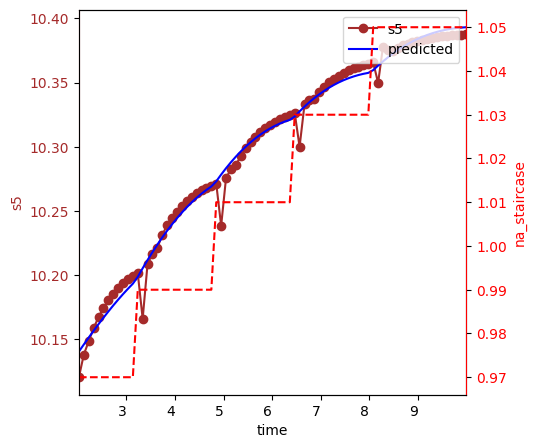

In [24]:
_ = CTLSB.plotTransferFunctionFit(num_zero=1, num_pole=2, fit_start_time=2,
      **OPERATING_REGION)

How to proceed from here:
1. Don't fit the initial transient. ``fit_start_time = 2``
2. Increase the number of poles.
3. Increase the number of zeroes.

In [25]:
WOLF_OLTF = CTLSB.getOpenLoopTransferFunction()
WOLF_OLTF

TransferFunction(array([1.06951085, 0.60410615]), array([0.68098187, 0.47710575, 0.30297564]))

In [26]:
WOLF_OLTF.poles(), WOLF_OLTF.zeros()

(array([-0.35030723+0.56762208j, -0.35030723-0.56762208j]),
 array([-0.56484341+0.j]))

# 4. Theory-based design

/usr/local/lib/python3.11/dist-packages/control/rlocus.py:210: FutureWarning:

root_locus() return value of roots, gains is deprecated; use root_locus_map()

/usr/local/lib/python3.11/dist-packages/control/pzmap.py:372: UserWarning:

axis already exists; grid keyword ignored



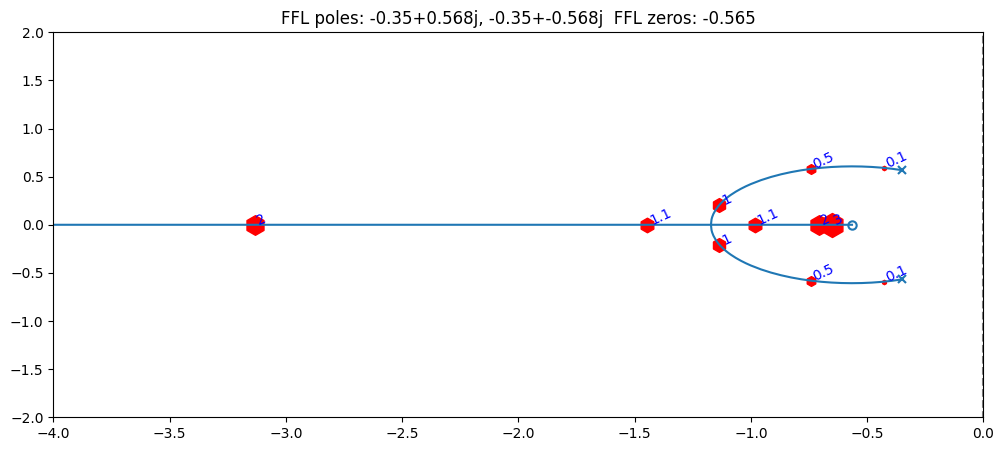

In [28]:
# P-control
_ = plotRootLocusWithGains(WOLF_OLTF, gains=[0.1, 0.5, 1, 1.1, 2, 3], xlim=[-4, 0], ylim=[-2, 2], figsize=(12, 5))

I control.
\begin{eqnarray}
C(s) &=& \frac{k_I}{s} \\
\end{eqnarray}

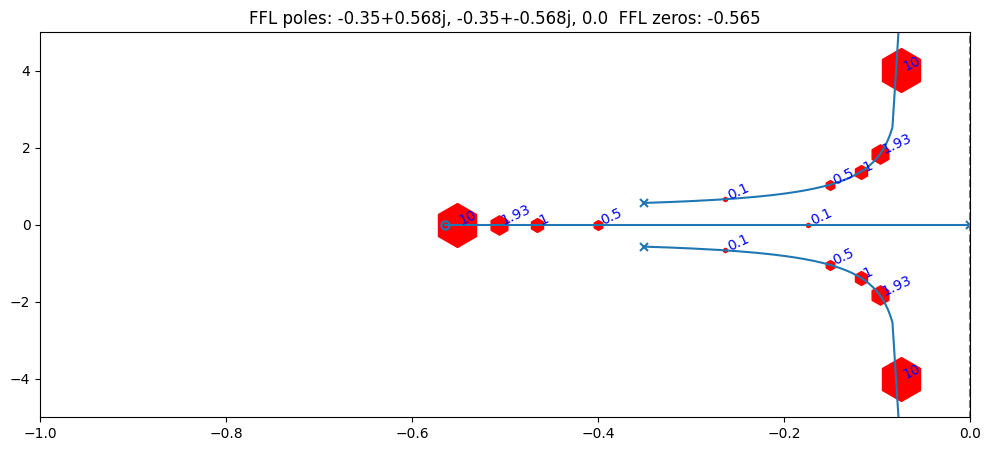

In [32]:
# I-control
s = control.TransferFunction.s
control_tf = control.TransferFunction([1], [1, 0])
_ = plotRootLocusWithGains(control_tf*WOLF_OLTF, gains=[0.1, 0.5, 1, 1.93, 10], xlim=[-1, 0], ylim=[-5, 5], figsize=(12, 5))

PI control. So
\begin{eqnarray}
C(s) &=& \frac{k_I + s k_P}{s} \\
 & = & k_P \frac{r_{IP} + s}{s}
\end{eqnarray}

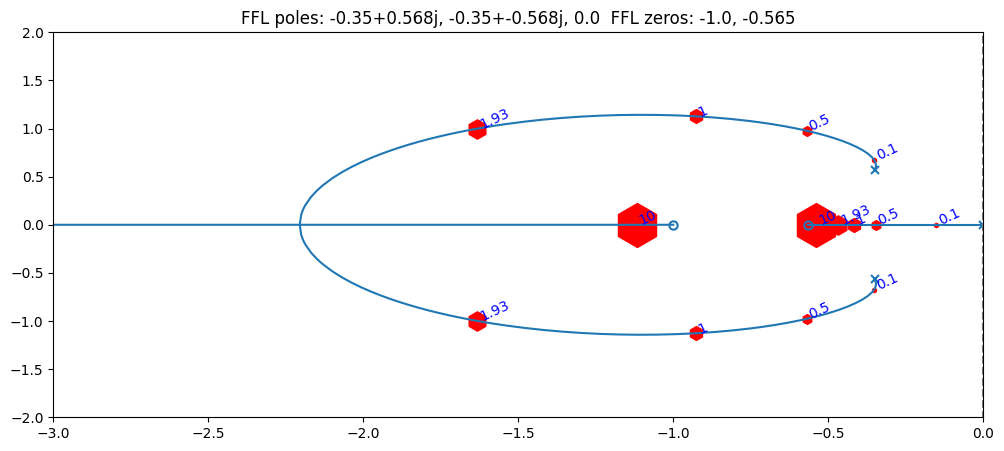

In [34]:
rIP = 1
s = control.TransferFunction.s
control_tf = control.TransferFunction([1, rIP], [1, 0])
_ = plotRootLocusWithGains(control_tf*WOLF_OLTF, gains=[0.1, 0.5, 1, 1.93, 10], xlim=[-3, 0], ylim=[-2, 2], figsize=(12, 5))

**Analysis of theory-based design**
1. We have two imaginary open loop poles and a pole at zero from I-control. So, we expect that a larger $k_P$ will do better.
1. We have an open loop zero at -0.565 from system identification. This is likely the smallest real, dominant pole that we can get.

# 5. Final design


Here, we build a closed loop system where the open loop is the SBML model of the simulated system. We use a PI controller. We examine both the output response and the value of the input. The latter is to ensure that we are within the operating region.

## Start from theory-based design

100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


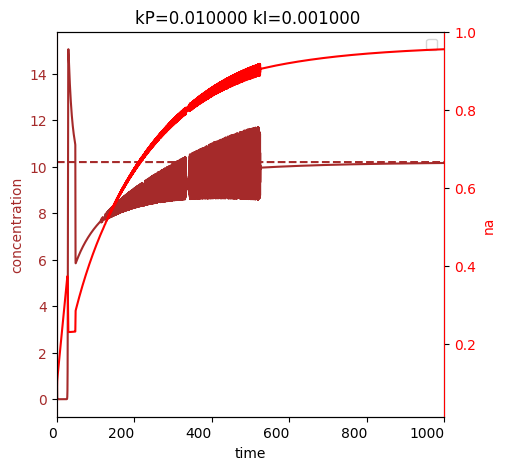

In [45]:
kP = 0.01
_ = CTLSB.plotDesign(kP_spec=kP, kI_spec=0.1*kP, title="", times=np.linspace(0, 1000, 10000), setpoint=10.2)

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_GenerativeAIImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_AltairImportHook.find_spec() not found; falling back to find_module()

100%|██████████| 1/1 [00:04<00:00,  4.47s/it]


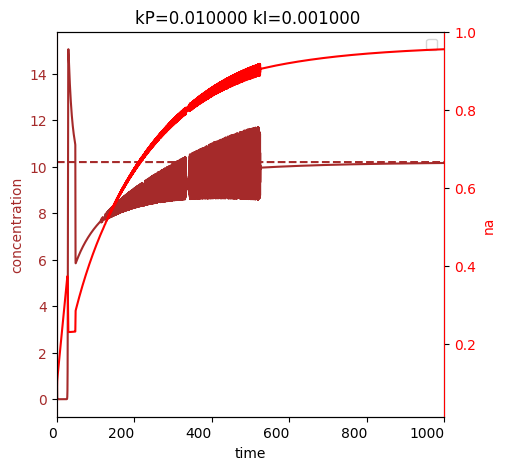

In [17]:
_ = CTLSB.plotDesign(kP_spec=0.01, kI_spec=0.001, title="", times=np.linspace(0, 1000, 10000), setpoint=10.2)

In [18]:
grid = Grid()
grid.addAxis("kP", min_value=0.01, max_value=0.1, num_coordinate=10)
grid.addAxis("kI", min_value=0.001, max_value=0.01, num_coordinate=10)
_ = CTLSB.plotDesign(kP_spec=0.55, kI_spec=True, title="", times=np.linspace(0, 1, 100), setpoint=10.2)
#_ = CTLSB.plotGridDesign(grid, title="", times=np.linspace(0, 200, 2000), setpoint=10.2)

In [19]:
grid = Grid()
grid.addAxis("kP", min_value=5, max_value=15, num_coordinate=10)
grid.addAxis("kI", min_value=5, max_value=15, num_coordinate=10)
#_ = CTLSB.plotGridDesign(grid, title="", times=np.linspace(0, 20, 200), setpoint=10.2)

The convergence failures likely mean that the actual system cannot handle the large values of $k_P, k_I$ that we're using. So, we need to back off on these.

## Manual tuning

In [20]:
grid = Grid()
grid.addAxis("kP", min_value=0.1, max_value=0.1, num_coordinate=10)
grid.addAxis("kI", min_value=0.1, max_value=0.1, num_coordinate=10)
#_ = CTLSB.plotGridDesign(grid, title="", times=np.linspace(0, 200, 2000), setpoint=10.2)

 64%|██████▍   | 64/100 [00:22<00:15,  2.30it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


 66%|██████▌   | 66/100 [00:23<00:15,  2.13it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


 67%|██████▋   | 67/100 [00:24<00:16,  1.98it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


 68%|██████▊   | 68/100 [00:24<00:16,  1.95it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


 69%|██████▉   | 69/100 [00:25<00:14,  2.18it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


 70%|███████   | 70/100 [00:25<00:12,  2.41it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


 74%|███████▍  | 74/100 [00:26<00:09,  2.89it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


 79%|███████▉  | 79/100 [00:27<00:05,  3.63it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


 80%|████████  | 80/100 [00:28<00:05,  3.45it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


 84%|████████▍ | 84/100 [00:29<00:05,  2.76it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


 85%|████████▌ | 85/100 [00:30<00:05,  2.65it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


 86%|████████▌ | 86/100 [00:30<00:05,  2.64it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


 89%|████████▉ | 89/100 [00:31<00:03,  3.17it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


 90%|█████████ | 90/100 [00:31<00:03,  3.15it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


 93%|█████████▎| 93/100 [00:32<00:02,  2.83it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


 95%|█████████▌| 95/100 [00:33<00:01,  2.94it/s]

CVODE Error: CV_ERR_FAILURE: Error test failures occurred too many times (= MXNEF = 7) during one internal time step oroccurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


 96%|█████████▌| 96/100 [00:33<00:01,  2.88it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


 97%|█████████▋| 97/100 [00:33<00:01,  2.91it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


 99%|█████████▉| 99/100 [00:34<00:00,  3.21it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


100%|██████████| 100/100 [00:34<00:00,  2.86it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


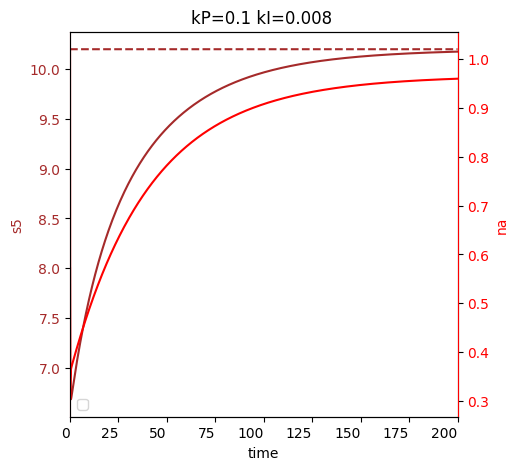

In [46]:
grid = Grid()
grid.addAxis("kP", min_value=0.01, max_value=0.1, num_coordinate=10)
grid.addAxis("kI", min_value=0.001, max_value=0.01, num_coordinate=10)
#_ = CTLSB.plotDesign(kP_spec=0.55, kI_spec=True, title="", times=np.linspace(0, 1, 100), setpoint=10.2)
_ = CTLSB.plotGridDesign(grid, title="", times=np.linspace(0, 200, 2000), setpoint=10.2, num_process=1)

# 6. Evaluate the final design

1. We need very small $k_P, k_I$ to make the system stable.
2. From the theory-based design, we see that this means that poles are near 0 and so the closed loop system is very slow.
3. The theory-based design provided a framework for tuning, but not reasonable estimates of the actual design parameters.